In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from scipy import stats

# from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', 100)

# Часть 1. EDA

#### 1.1 Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [221]:
df = pd.read_csv('data/AB_NYC_2019.csv', index_col=0)

In [222]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,149,1,9,2018-10-19,0.2100,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,45,2019-05-21,0.3800,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.8090,-73.9419,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.6851,-73.9598,Entire home/apt,89,1,270,2019-07-05,4.6400,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.7985,-73.9440,Entire home/apt,80,10,9,2018-11-19,0.1000,1,0


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 2539 to 36487245
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month              

In [224]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,"48,895.0000","48,895.0000","48,895.0000","48,895.0000","48,895.0000","48,895.0000","38,843.0000","48,895.0000","48,895.0000"
mean,"67,620,010.6466",40.7289,-73.9522,152.7207,7.0300,23.2745,1.3732,7.1440,112.7813
std,"78,610,967.0327",0.0545,0.0462,240.1542,20.5105,44.5506,1.6804,32.9525,131.6223
min,"2,438.0000",40.4998,-74.2444,0.0000,1.0000,0.0000,0.0100,1.0000,0.0000
25%,"7,822,033.0000",40.6901,-73.9831,69.0000,1.0000,1.0000,0.1900,1.0000,0.0000
50%,"30,793,816.0000",40.7231,-73.9557,106.0000,3.0000,5.0000,0.7200,1.0000,45.0000
75%,"107,434,423.0000",40.7631,-73.9363,175.0000,5.0000,24.0000,2.0200,2.0000,227.0000
max,"274,321,313.0000",40.9131,-73.7130,"10,000.0000","1,250.0000",629.0000,58.5000,327.0000,365.0000


### 1.2 Пройдите по основным шагам работы с данными:

#### 1.2.1 Выкиньте ненужные признаки: id, name, host_id, host_name, last_review
- визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots
- по результатам анализа произведите предобработку переменных

In [225]:
df = df.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1)

#### 1.2.2 Визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots

Начнем с числовых признаков

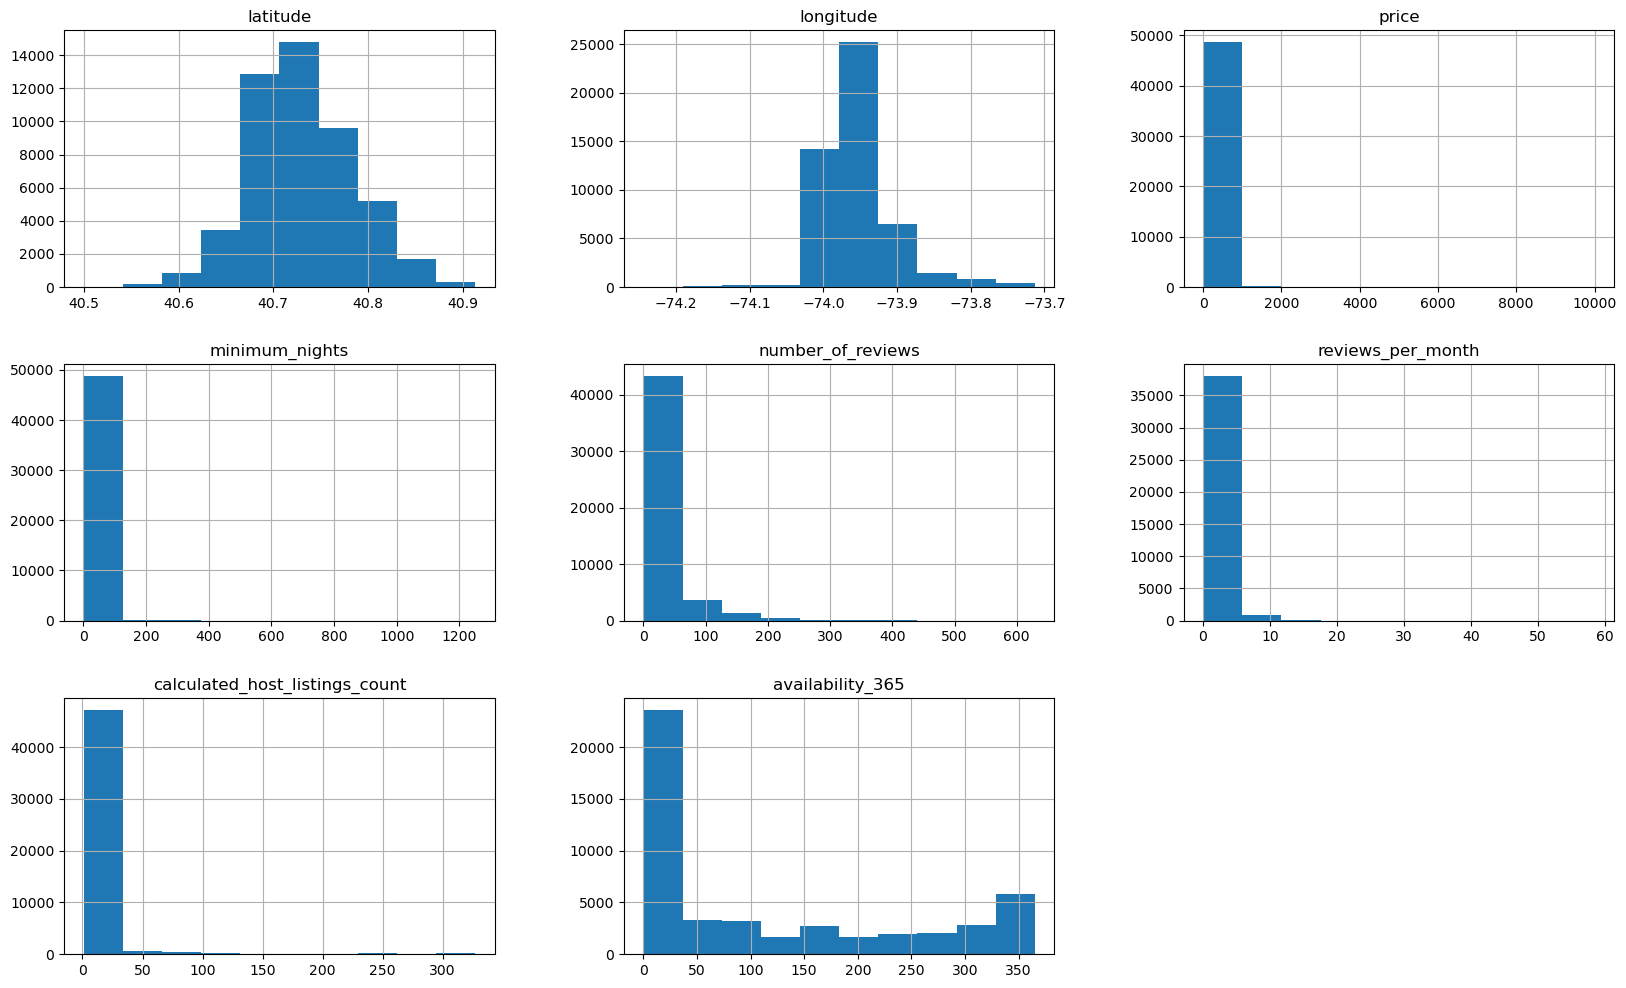

In [226]:
df.hist(figsize=(20,12));

Распределения числовых признаков, и в частности, цены, сильно сдвинуты влево, что говорит о наличии выбросов. Помимо числовых признаков, в наборе есть три категориальных - посмотрим на них более детально

In [227]:
df.describe(include='object')

,neighbourhood_group,neighbourhood,room_type
count,48895,48895,48895
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21661,3920,25409


In [228]:
df.select_dtypes(include='object').columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [229]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

<Axes: >

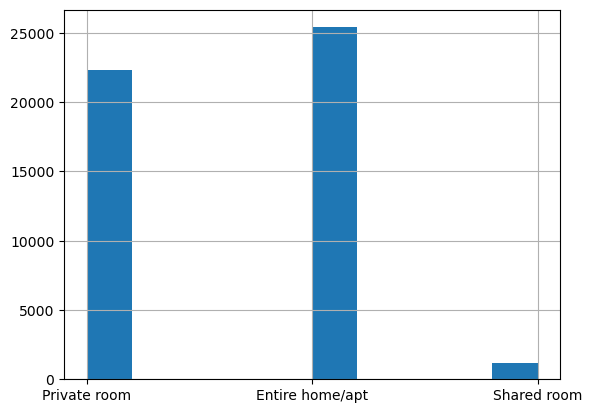

In [230]:
df['room_type'].hist()

In [231]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

<Axes: >

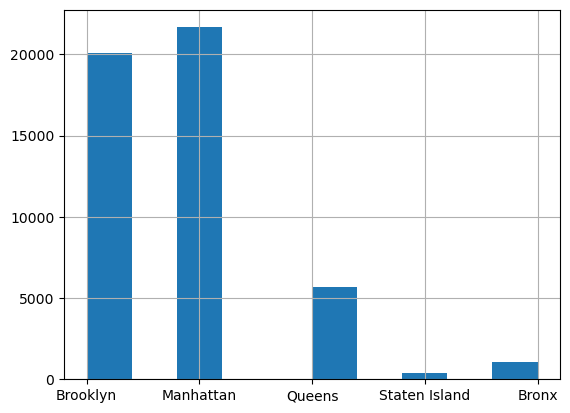

In [232]:
df['neighbourhood_group'].hist()

In [233]:
df['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [234]:
df_gb_nbrh = df.groupby(['neighbourhood'])['neighbourhood'].count()

In [235]:
df_gb_nbrh.sort_values(ascending=False).head(10)

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

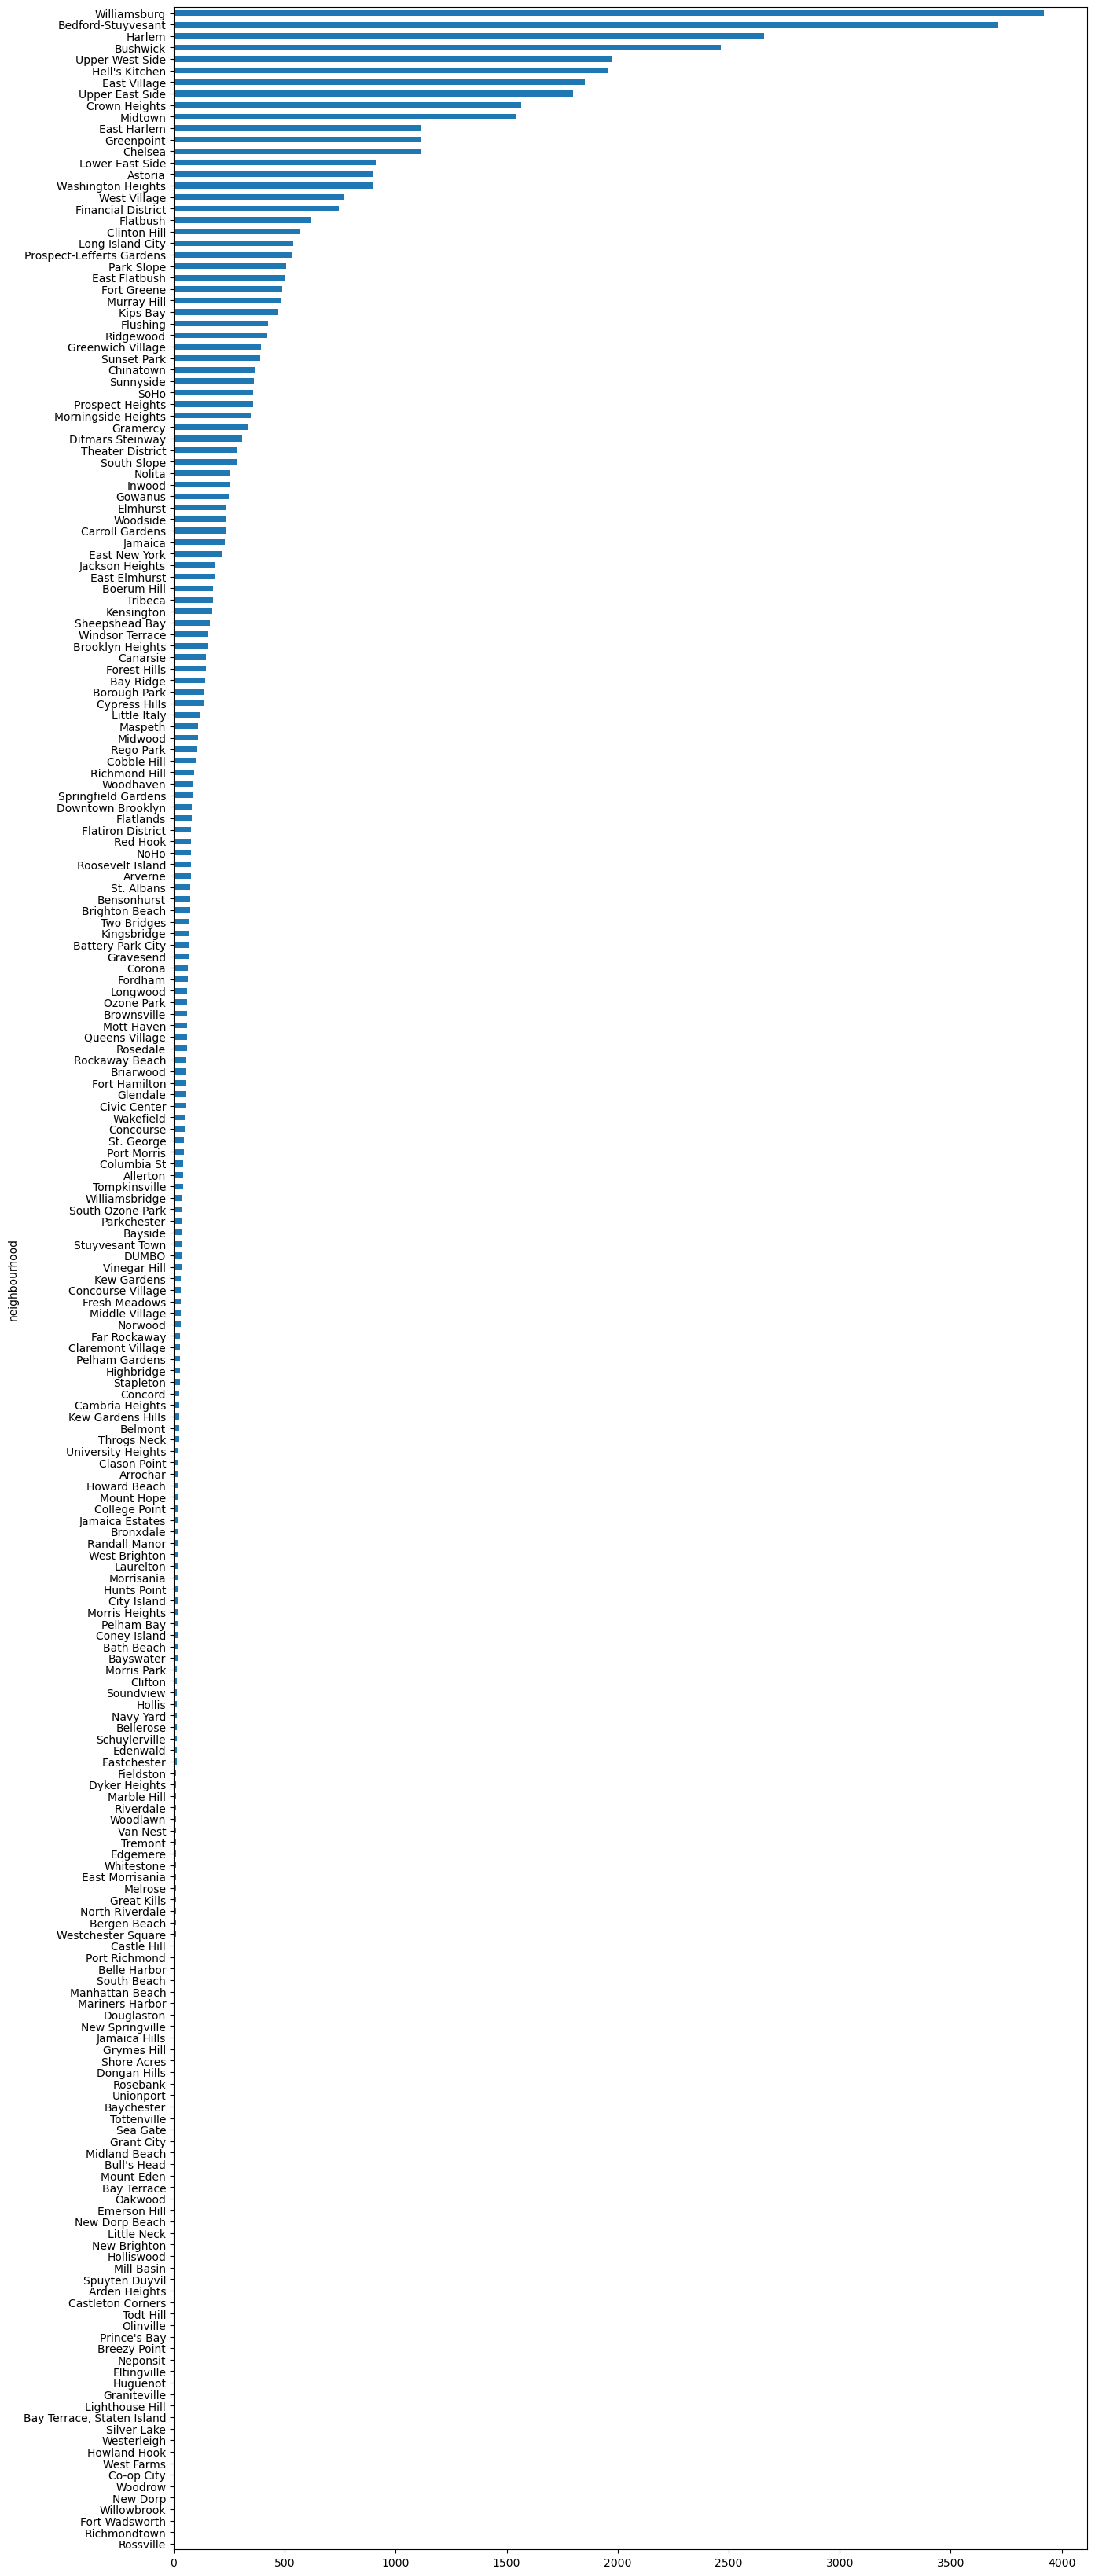

In [236]:
df_gb_nbrh.sort_values(ascending=True).plot.barh(figsize=(15,42));

In [237]:
df[['room_type','neighbourhood_group','neighbourhood']].nunique()

room_type                3
neighbourhood_group      5
neighbourhood          221
dtype: int64

Посмотрим на зависимость цены от типа комнаты и местоположения

Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

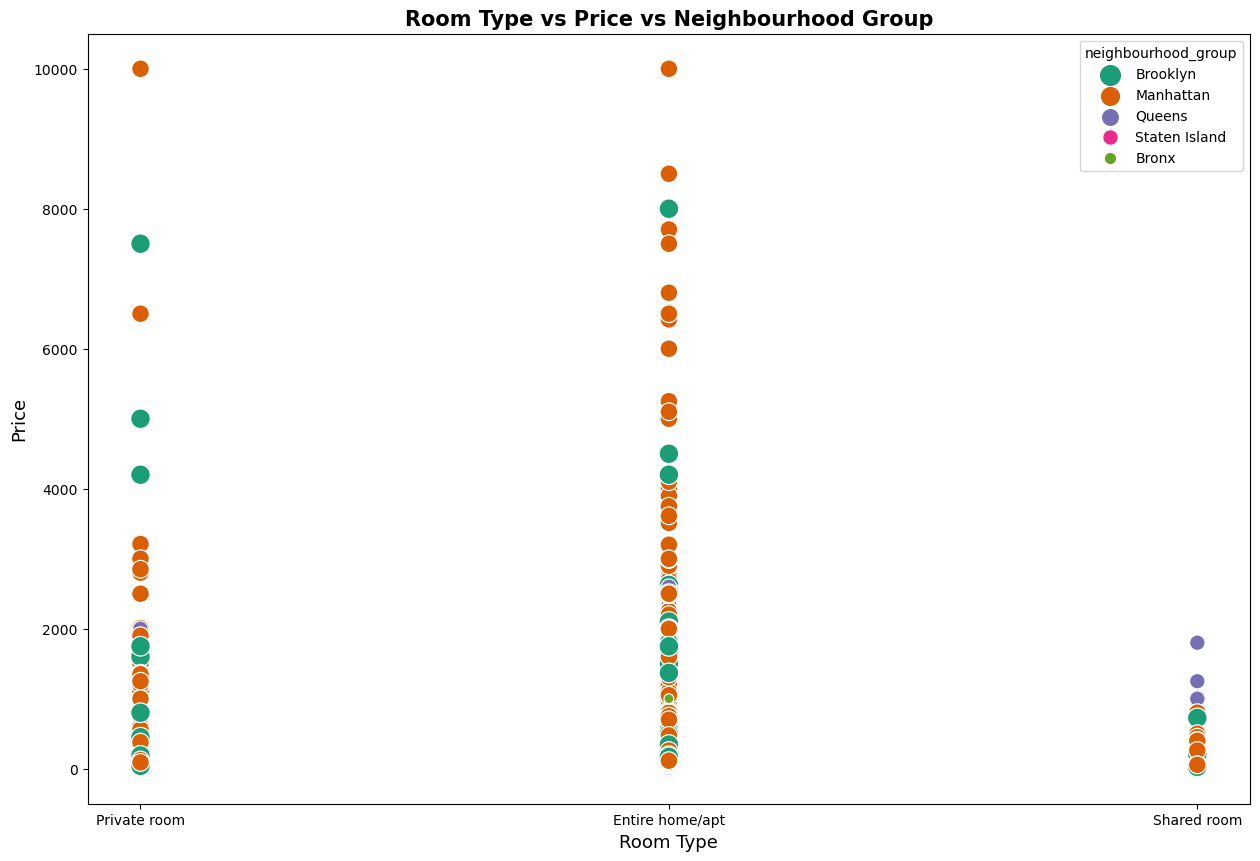

In [238]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="Dark2", data=df)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

Стоимость shared room не поднимается выше 2000, при этом самая высокая стоимость аренды, ожидаемо, на Манхэттене, следом за ним идет Бруклин

<Axes: xlabel='price', ylabel='Count'>

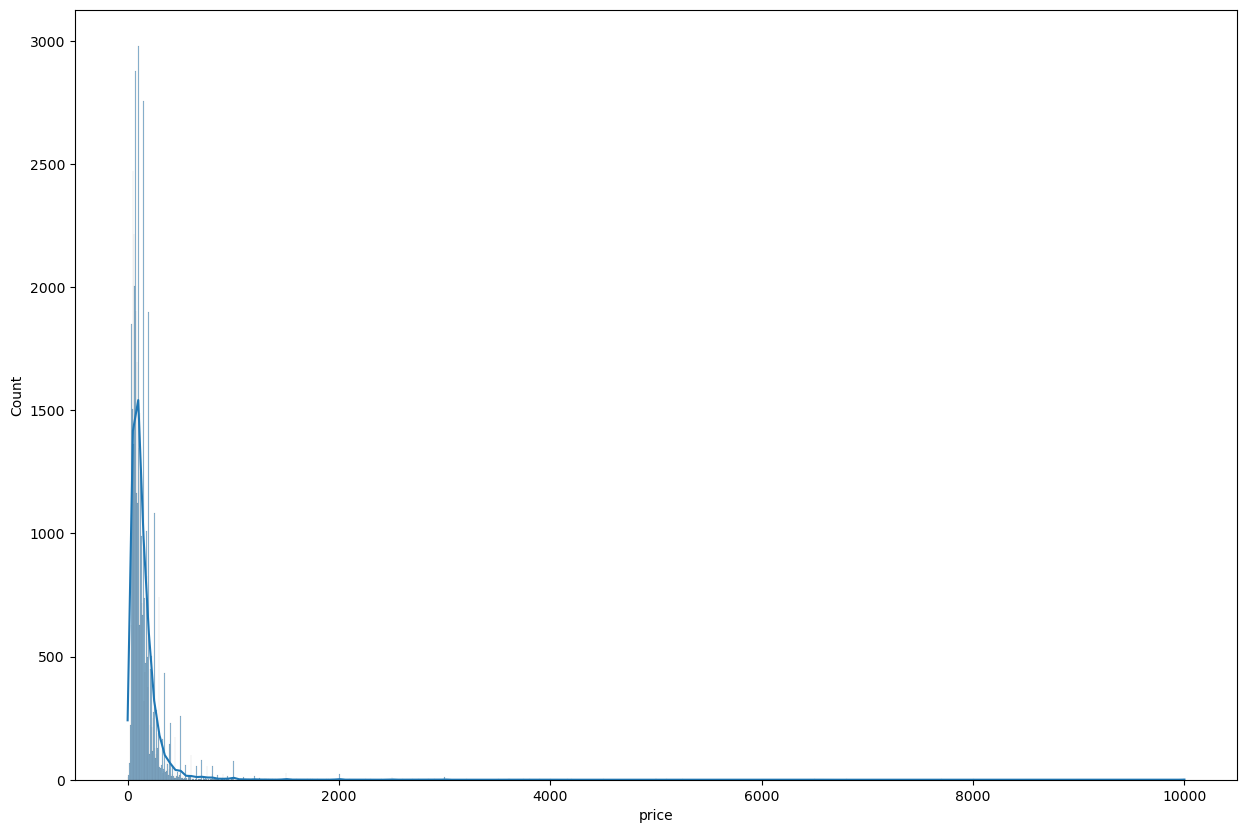

In [239]:
plt.figure(figsize=(15,10))
#sns.displot(data=df, x='price', kde=True)
sns.histplot(data=df, x='price', kde=True)

In [240]:
df.price.describe()

count   48,895.0000
mean       152.7207
std        240.1542
min          0.0000
25%         69.0000
50%        106.0000
75%        175.0000
max     10,000.0000
Name: price, dtype: float64

Построим boxplot

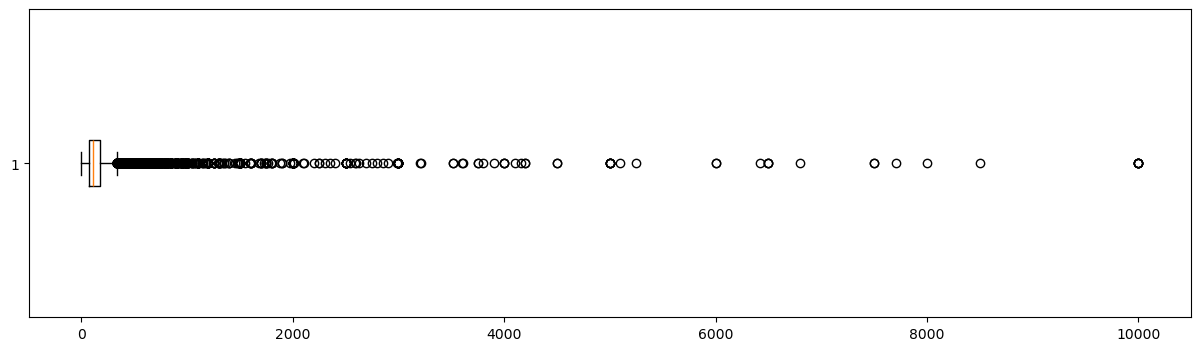

In [241]:
fig = plt.figure(figsize =(15, 4))
 
plt.boxplot(df['price'], vert=0)
plt.show()

In [242]:
IQR = df['price'].quantile(q=0.75) - df['price'].quantile(q=0.25)

In [243]:
IQR

106.0

In [244]:
r_bound = df['price'].quantile(q=0.75) + 1.5*IQR

In [245]:
r_bound

334.0

Для построения матрицы корреляций сделаем быстрый маппинг категориальных признаков с использованием cat.codes

In [246]:
data_nyc = df.copy()

In [247]:
data_nyc['neighbourhood_group']= data_nyc['neighbourhood_group'].astype("category").cat.codes
data_nyc['neighbourhood'] = data_nyc['neighbourhood'].astype("category").cat.codes
data_nyc['room_type'] = data_nyc['room_type'].astype("category").cat.codes

In [248]:
data_nyc.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
2539,1,108,40.6475,-73.9724,1,149,1,9,0.2100,6,365
2595,2,127,40.7536,-73.9838,0,225,1,45,0.3800,2,355
3647,2,94,40.8090,-73.9419,1,150,3,0,NaN,1,365
3831,1,41,40.6851,-73.9598,0,89,1,270,4.6400,1,194
5022,2,61,40.7985,-73.9440,0,80,10,9,0.1000,1,0


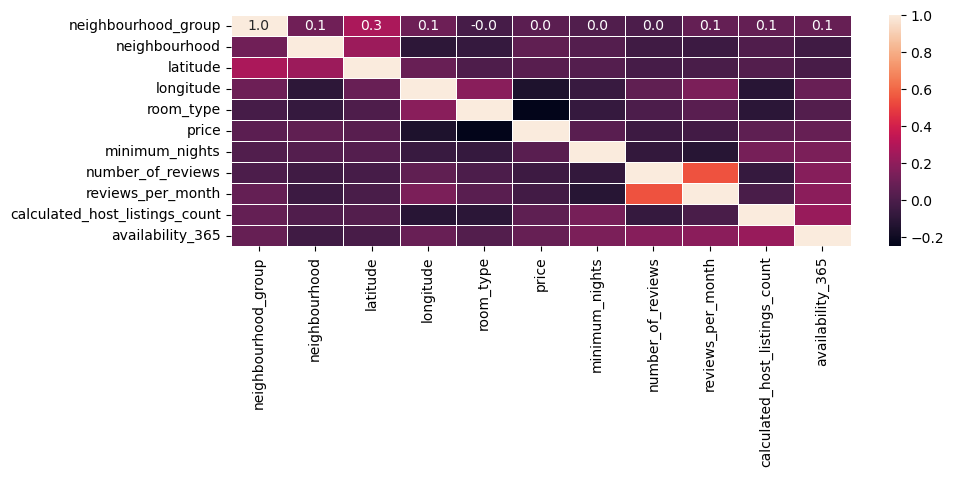

In [249]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(data_nyc.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

Видим, что зависимость между признаками и ценой низкая - для модели будем использовать все атрибуты

включить перед отправкой

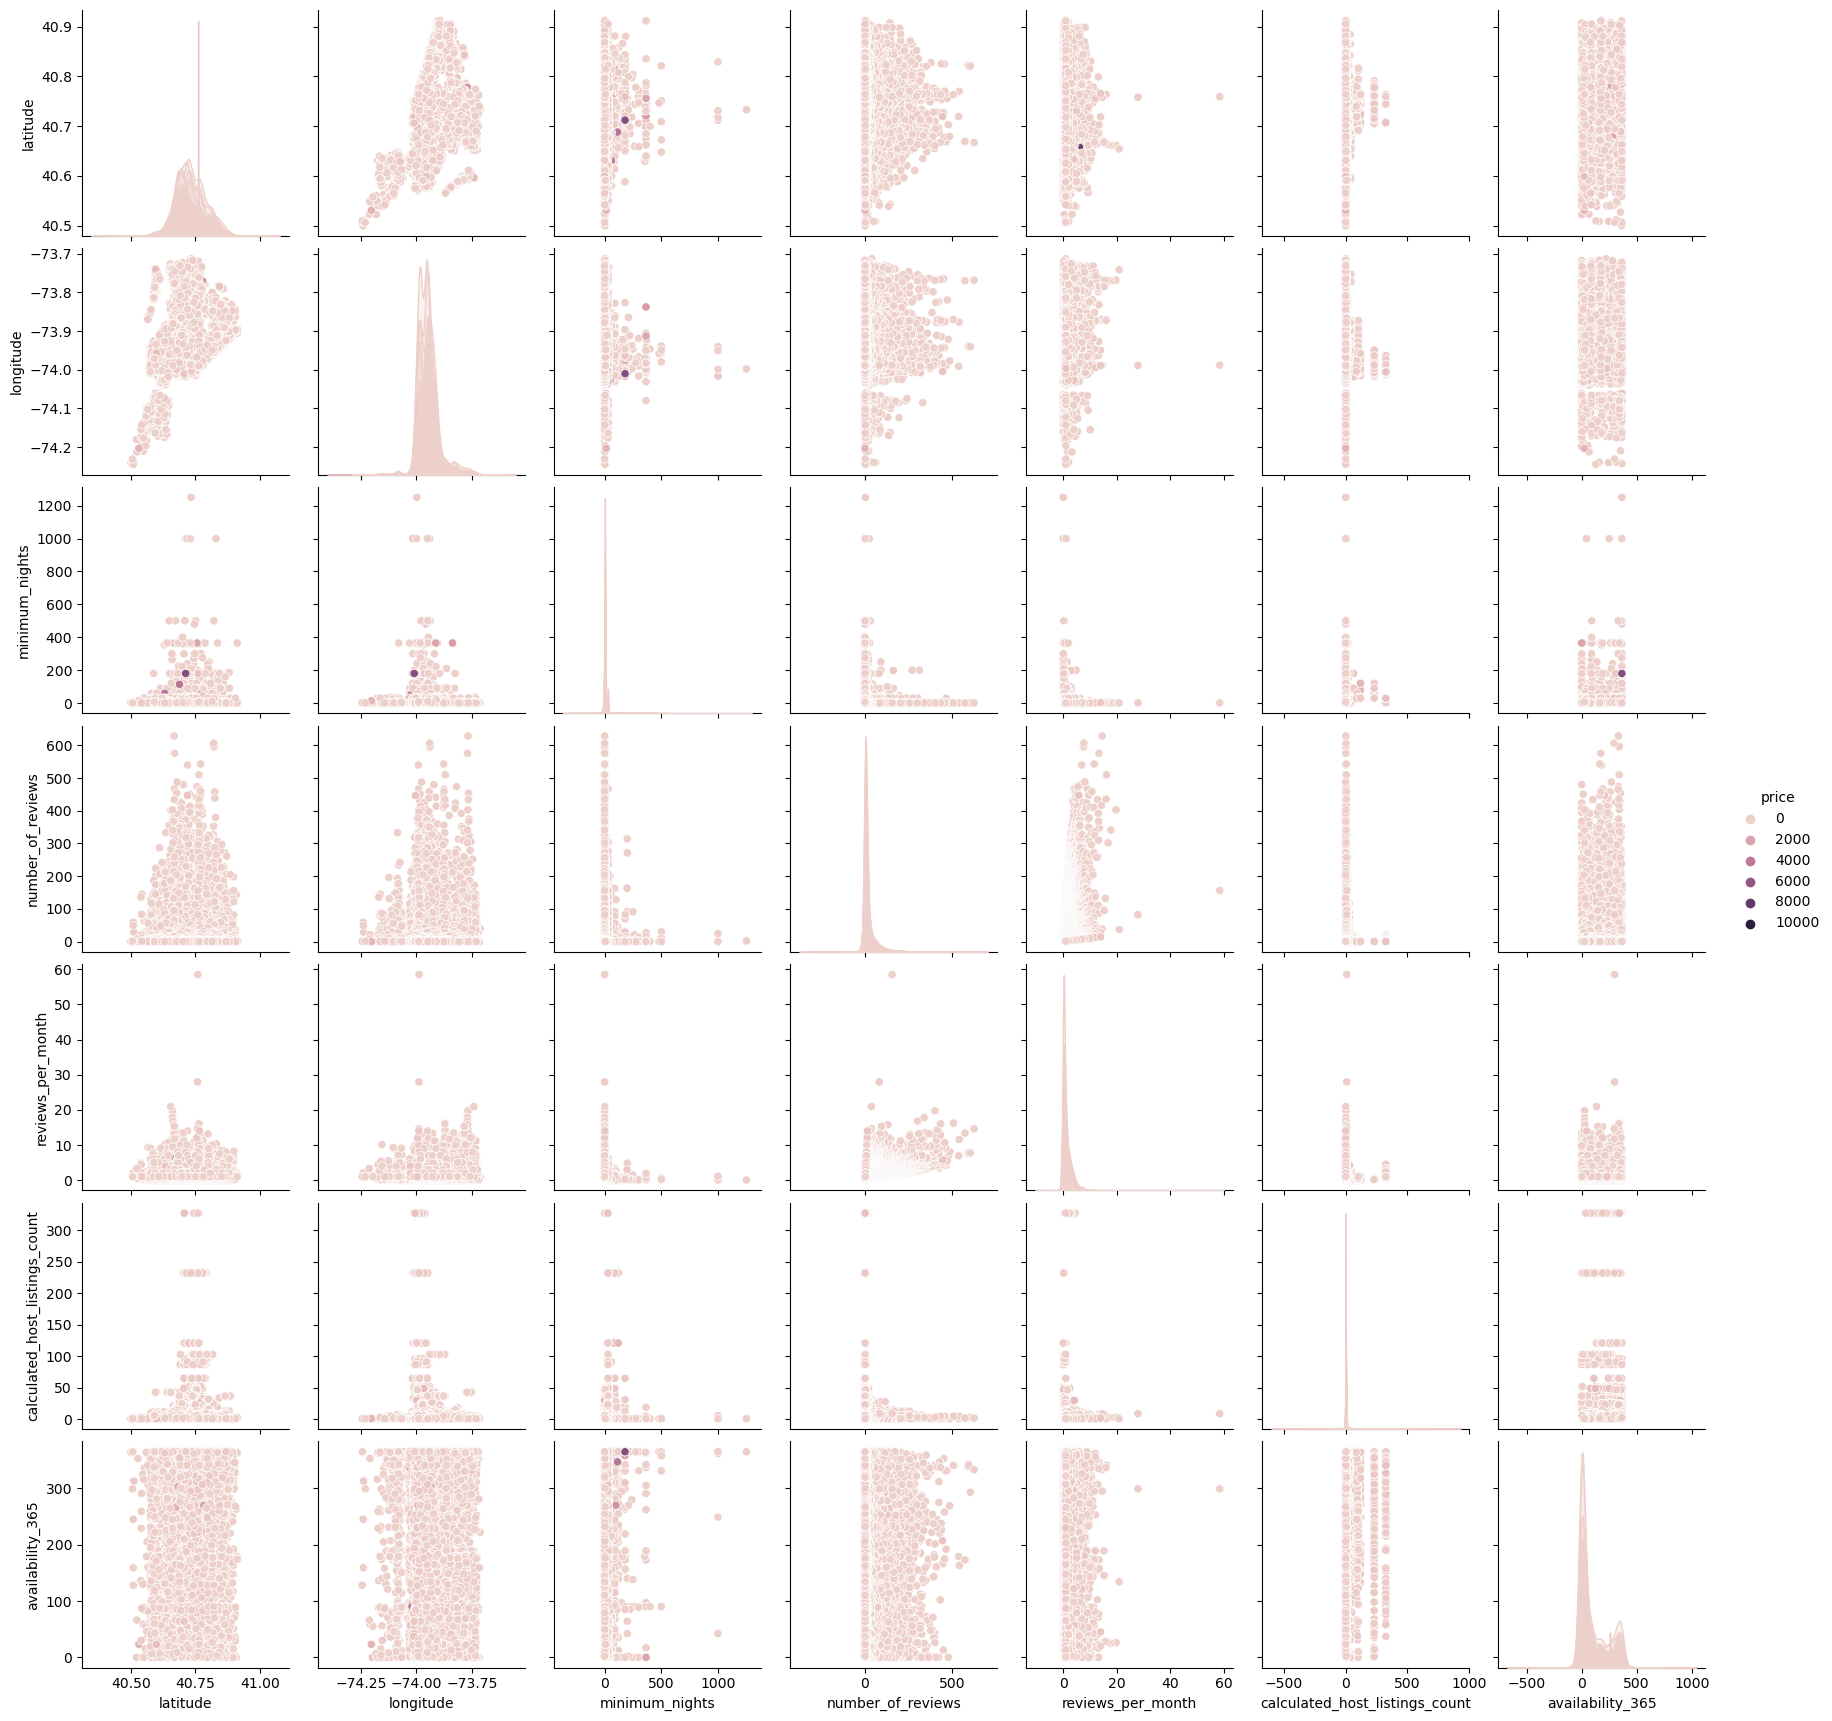

In [250]:
sns.pairplot(data=df, hue='price')
plt.show;

#### 1.2.3 По результатам анализа произведите предобработку переменных


Признак review_per_month имеет null-значения

In [251]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Посмотрим на пропущенные значения

In [252]:
df[df['reviews_per_month'].isna() == True]
# df[pd.isnull(df.reviews_per_month)]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
3647,Manhattan,Harlem,40.8090,-73.9419,Private room,150,3,0,NaN,1,365
7750,Manhattan,East Harlem,40.7968,-73.9487,Entire home/apt,190,7,0,NaN,2,249
8700,Manhattan,Inwood,40.8675,-73.9264,Private room,80,4,0,NaN,1,0
11452,Brooklyn,Bedford-Stuyvesant,40.6888,-73.9431,Private room,35,60,0,NaN,1,365
11943,Brooklyn,Flatbush,40.6370,-73.9633,Private room,150,1,0,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...
36484665,Brooklyn,Bedford-Stuyvesant,40.6785,-73.9500,Private room,70,2,0,NaN,2,9
36485057,Brooklyn,Bushwick,40.7018,-73.9332,Private room,40,4,0,NaN,2,36
36485431,Manhattan,Harlem,40.8147,-73.9487,Entire home/apt,115,10,0,NaN,1,27


Видим, что признак review_per_month не заполнен там, где number_of_reviews=0. Соответственно, для дальнейшей работы, заменим null-значения признака review_per_month на 0.

In [253]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [254]:
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Как мы ранее видели, распределение цены сильно сдвинуто влево и линейная модель плохо подходит для предсказания таких данных

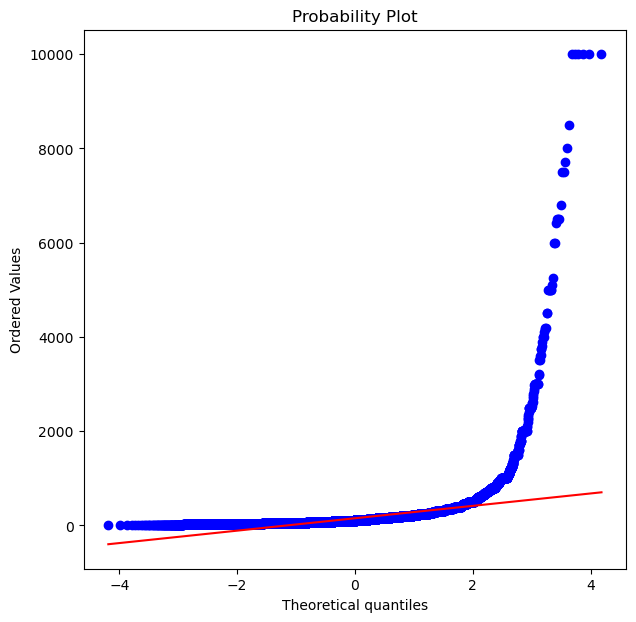

In [255]:
plt.figure(figsize=(7,7))
stats.probplot(df['price'], plot=plt)
plt.show()

Поэтому, проведем логарифмическое преобразование для "нормализации" распределения целевой переменной 

In [256]:
df['price_log'] = np.log(df.price+1)

<Axes: xlabel='price_log', ylabel='Count'>

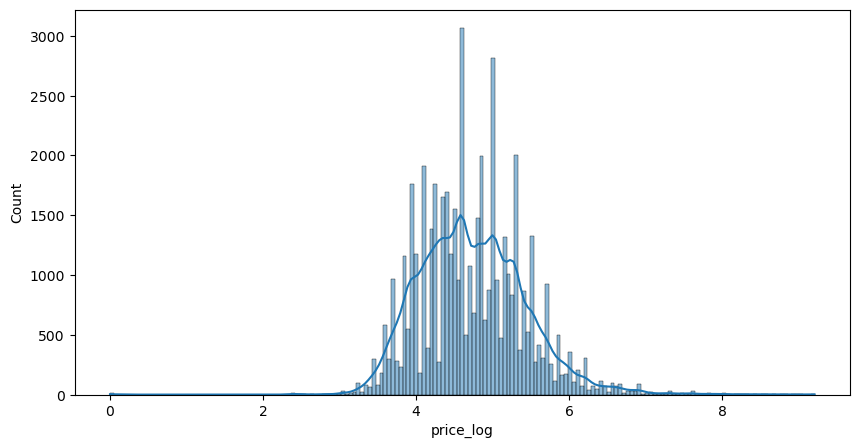

In [257]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='price_log', kde=True)

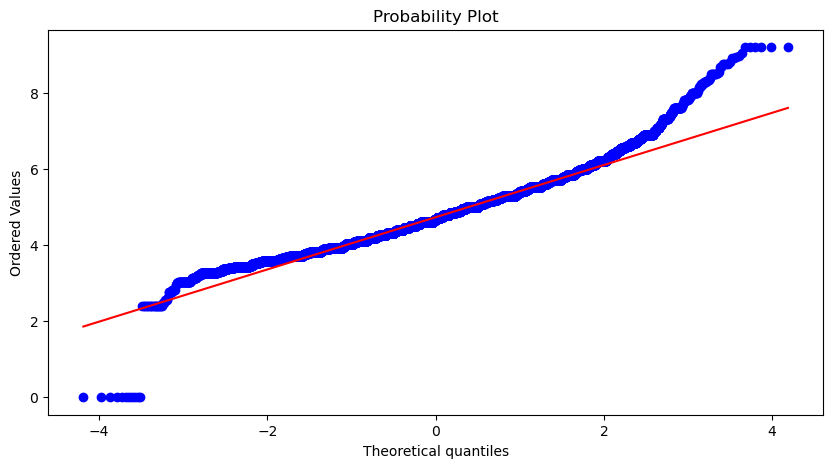

In [258]:
plt.figure(figsize=(10,5))
stats.probplot(df['price_log'], plot=plt)
plt.show()

## Часть 2. Preprocessing & Feature Engineering
Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
Опробуйте различные техники:
- работа с категориальными переменными (можно начать с dummy);
- замена аномалий;
- различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);
- обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;

Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.

Опробуйте различные техники:
- работа с категориальными переменными (можно начать с dummy);

Определим функцию кодировки категориальных признаков выбранным методом

In [259]:
df.select_dtypes(include=['object']).columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [260]:
def onehot_encode_func(data, cols = ['neighbourhood_group', 'neighbourhood', 'room_type']):
    data_enc = data.copy()
    data_enc = pd.get_dummies(data_enc, columns=cols, dtype=float)
    return data_enc

In [261]:
def count_encode_func(data, cols = ['neighbourhood_group', 'neighbourhood', 'room_type']):
    enc = CountEncoder()
    data_enc = data.copy()
    data_enc[cols]= enc.fit_transform(data_enc[cols])
    return data_enc

In [262]:
df_ce = count_encode_func(df)

In [263]:
df_ce

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
id,,,,,,,,,,,,
2539,20104,175,40.6475,-73.9724,22326,149,1,9,0.2100,6,365,5.0106
2595,21661,1545,40.7536,-73.9838,25409,225,1,45,0.3800,2,355,5.4205
3647,21661,2658,40.8090,-73.9419,22326,150,3,0,0.0000,1,365,5.0173
3831,20104,572,40.6851,-73.9598,25409,89,1,270,4.6400,1,194,4.4998
5022,21661,1117,40.7985,-73.9440,25409,80,10,9,0.1000,1,0,4.3944
...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,20104,3714,40.6785,-73.9500,22326,70,2,0,0.0000,2,9,4.2627
36485057,20104,2465,40.7018,-73.9332,22326,40,4,0,0.0000,2,36,3.7136
36485431,21661,2658,40.8147,-73.9487,25409,115,10,0,0.0000,1,27,4.7536


In [264]:
df_ohe = onehot_encode_func(df)

In [265]:
df_ohe.shape

(48895, 238)

In [266]:
df_ohe.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price_log', 'neighbourhood_group_Bronx',
       ...
       'neighbourhood_Williamsburg', 'neighbourhood_Willowbrook',
       'neighbourhood_Windsor Terrace', 'neighbourhood_Woodhaven',
       'neighbourhood_Woodlawn', 'neighbourhood_Woodrow',
       'neighbourhood_Woodside', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=238)

## Часть 3. Моделирование

1. Отложите 30% данных для тестирования.
2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
3. Измерьте качество каждой и визуализируйте важность признаков.
4. Сделайте интересные выводы :)
5. В ноутбуке желательно видеть:

- Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
- Наличие визуализаций (не обязательно строить много графиков - можно несколько репрезентативных).
- Наличие хотя бы одной модификации данных, приводящей к улучшению результатов.


1. Отложите 30% данных для тестирования.

- df_ce - Count encoded dataset
- df_ohe - OneHot encoded dataset

2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.

Создадим функцию оценки качества модели

In [267]:
def evaluate_model(data_enc, model, scaler, tv='price'):
    X_train, X_test, y_train, y_test = train_test_split(data_enc.drop(['price', 'price_log'], axis=1), \
                                                        data_enc[tv], test_size=0.3, random_state=13)
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
  
    mae = round(mean_absolute_error(y_test, y_pred),4)
    mae_norm = round(mean_absolute_error(y_test, y_pred)/np.mean(y_test), 4)
    mse = round(mean_squared_error(y_test, y_pred), 4)
    R2 = round(r2_score(y_test, y_pred), 4)
    
#    print('MAE: ', round(mae,4))
#    print('MAE norm: ', round(mae_norm,4))
#    print('MSE: ', round(mse,4))
#    print('R2: ', round(R2,4))

    return [round(mae,4), round(mae_norm,4), round(mse,4), round(R2,4)]

In [268]:
results = {}

In [269]:
lr = LinearRegression()
lasso = LassoCV()
ridge = RidgeCV()
elastic = ElasticNetCV()

In [270]:
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

## Count Encoding - Standard Scaler

In [271]:
results['Count encoding - Linear - Standard Scaler'] = evaluate_model(df_ce, lr, std_scaler, tv='price')

In [272]:
results['Count encoding - Lasso - Standard Scaler'] = evaluate_model(df_ce, lasso, std_scaler, tv='price')

In [273]:
results['Count encoding - Ridge - Standard Scaler'] = evaluate_model(df_ce, ridge, std_scaler, tv='price')

In [274]:
results['Count encoding - Elastic - Standard Scaler'] = evaluate_model(df_ce, elastic, std_scaler, tv='price')

## Count Encoding - Robust Scaler

In [275]:
results['Count encoding - Linear - Robust Scaler'] = evaluate_model(df_ce, lr, robust_scaler, tv='price')
results['Count encoding - Lasso - Robust Scaler'] = evaluate_model(df_ce, lasso, robust_scaler, tv='price')
results['Count encoding - Ridge - Robust Scaler'] = evaluate_model(df_ce, ridge, robust_scaler, tv='price')
results['Count encoding - Elastic - Robust Scaler'] = evaluate_model(df_ce, elastic, robust_scaler, tv='price')

## OneHot Encoding - Standard Scaler

In [276]:
results['OneHot encoding - Linear - Standard Scaler'] = evaluate_model(df_ohe, lr, std_scaler, tv='price')
results['OneHot encoding - Lasso - Standard Scaler'] = evaluate_model(df_ohe, lasso, std_scaler, tv='price')
results['OneHot encoding - Ridge - Standard Scaler'] = evaluate_model(df_ohe, ridge, std_scaler, tv='price')
results['OneHot encoding - Elastic - Standard Scaler'] = evaluate_model(df_ohe, elastic, std_scaler, tv='price')

## OneHot Encoding - Robust Scaler

In [277]:
results['OneHot encoding - Linear - Robust Scaler'] = evaluate_model(df_ohe, lr, robust_scaler, tv='price')
results['OneHot encoding - Lasso - Robust Scaler'] = evaluate_model(df_ohe, lasso, robust_scaler, tv='price')
results['OneHot encoding - Ridge - Robust Scaler'] = evaluate_model(df_ohe, ridge, robust_scaler, tv='price')
results['OneHot encoding - Elastic - Robust Scaler'] = evaluate_model(df_ohe, elastic, robust_scaler, tv='price')

In [278]:
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(results, index = ['MAE', 'MAE/Mean', 'MSE', 'R2']).T

,MAE,MAE/Mean,MSE,R2
Count encoding - Linear - Standard Scaler,82.9655,0.5481,"54,174.9141",0.0520
Count encoding - Lasso - Standard Scaler,82.7244,0.5466,"54,159.9963",0.0523
Count encoding - Ridge - Standard Scaler,82.9632,0.5481,"54,174.6987",0.0520
Count encoding - Elastic - Standard Scaler,82.6966,0.5464,"54,153.0410",0.0524
Count encoding - Linear - Robust Scaler,82.9655,0.5481,"54,174.9141",0.0520
Count encoding - Lasso - Robust Scaler,82.7244,0.5466,"54,159.9963",0.0523
Count encoding - Ridge - Robust Scaler,82.9632,0.5481,"54,174.6987",0.0520
Count encoding - Elastic - Robust Scaler,82.6966,0.5464,"54,153.0410",0.0524
OneHot encoding - Linear - Standard Scaler,"92,696,615,199.4398","612,439,634.3291","42,086,802,054,193,675,696,603,136.0000","-736,452,883,053,591,134,208.0000"
OneHot encoding - Lasso - Standard Scaler,70.6589,0.4668,"51,425.2888",0.1001


Видим, что с OneHot Encoding'ом линейная модель не справляется категорически, но и более продвинутые модели показывают низкие результаты. Поэтому, дополним таблицу результатами логарифмической целевой переменной.

## Count Encoding - Standard Scaler - Log Price

In [279]:
results['Count encoding - Linear - Standard Scaler - LogPrice'] = evaluate_model(df_ce, lr, std_scaler, tv='price_log')

In [280]:
results['Count encoding - Lasso - Standard Scaler - LogPrice'] = evaluate_model(df_ce, lasso, std_scaler, tv='price_log')

In [281]:
results['Count encoding - Ridge - Standard Scaler - LogPrice'] = evaluate_model(df_ce, ridge, std_scaler, tv='price_log')

In [282]:
results['Count encoding - Elastic - Standard Scaler - LogPrice'] = evaluate_model(df_ce, elastic, std_scaler, tv='price_log')

## Count Encoding - Robust Scaler - Log Price

In [283]:
results['Count encoding - Linear - Robust Scaler - Log Price'] = evaluate_model(df_ce, lr, robust_scaler, tv='price_log')

In [284]:
results['Count encoding - Lasso - Robust Scaler - Log Price'] = evaluate_model(df_ce, lasso, robust_scaler, tv='price_log')

In [285]:
results['Count encoding - Ridge - Robust Scaler - Log Price'] = evaluate_model(df_ce, ridge, robust_scaler, tv='price_log')

In [286]:
results['Count encoding - Elastic - Robust Scaler - Log Price'] = evaluate_model(df_ce, elastic, robust_scaler, tv='price_log')

## OneHot Encoding - Standard Scaler - Log Price

In [287]:
results['OneHot encoding - Linear - Standard Scaler - Log Price'] = evaluate_model(df_ohe, lr, std_scaler, tv='price_log')

In [288]:
results['OneHot encoding - Lasso - Standard Scaler - Log Price'] = evaluate_model(df_ohe, lasso, std_scaler, tv='price_log')

In [289]:
results['OneHot encoding - Ridge - StandardScaler - Log Price'] = evaluate_model(df_ohe, ridge, std_scaler, tv='price_log')

In [290]:
results['OneHot encoding - Elastic - Standard Scaler - Log Price'] = evaluate_model(df_ohe, elastic, std_scaler, tv='price_log')

## OneHot Encoding - Robust Scaler - Log Price

In [291]:
results['OneHot encoding - Linear - Robust Scaler - Log Price'] = evaluate_model(df_ohe, lr, robust_scaler, tv='price_log')

In [292]:
results['OneHot encoding - Lasso - Robust Scaler - Log Price'] = evaluate_model(df_ohe, lasso, robust_scaler, tv='price_log')

In [293]:
results['OneHot encoding - Ridge - Robust Scaler - Log Price'] = evaluate_model(df_ohe, ridge, robust_scaler, tv='price_log')

In [294]:
results['OneHot encoding - Elastic - Robust Scaler - Log Price'] = evaluate_model(df_ohe, elastic, robust_scaler, tv='price_log')

## Посмотрим на сводную таблицу с результатами

In [295]:
pd.DataFrame(results, index = ['MAE', 'MAE/Mean', 'MSE', 'R2']).T

,MAE,MAE/Mean,MSE,R2
Count encoding - Linear - Standard Scaler,82.9655,0.5481,"54,174.9141",0.0520
Count encoding - Lasso - Standard Scaler,82.7244,0.5466,"54,159.9963",0.0523
Count encoding - Ridge - Standard Scaler,82.9632,0.5481,"54,174.6987",0.0520
Count encoding - Elastic - Standard Scaler,82.6966,0.5464,"54,153.0410",0.0524
Count encoding - Linear - Robust Scaler,82.9655,0.5481,"54,174.9141",0.0520
Count encoding - Lasso - Robust Scaler,82.7244,0.5466,"54,159.9963",0.0523
Count encoding - Ridge - Robust Scaler,82.9632,0.5481,"54,174.6987",0.0520
Count encoding - Elastic - Robust Scaler,82.6966,0.5464,"54,153.0410",0.0524
OneHot encoding - Linear - Standard Scaler,"92,696,615,199.4398","612,439,634.3291","42,086,802,054,193,675,696,603,136.0000","-736,452,883,053,591,134,208.0000"
OneHot encoding - Lasso - Standard Scaler,70.6589,0.4668,"51,425.2888",0.1001


Видим, что с предсказанием логарифмической целевой переменной модели справляются на два порядка лучше (за исключением базовой модели линейной регрессии, здесь наблюдается полный провал), а самые лучшие результаты показывают продвинутые линейные модели вместе с использованием OneHot Encoding'a, при этом существенные отличия между использованием Standard Scaler'a и Robust Scaler'а отсутствуют.